# Algorytmy wspomagania decyzji
***
### Termin: Czwartek 11:15-13:00 TP,
### Prowadzący: Mgr inż. Cyprian Mataczyński,
### Grupa: Adrian Sobecki 248942, Mateusz Tkacz 248961
### Temat projektu: Zastosowanie algorytmu k-najbliższych sąsiadów do rozpoznawania chorób serca

***

### Cel i zakres projektu: 
#### Tematem projektu będzie zastosowanie algorytmu k-najbliższych sąsiadów do rozpoznawania chorób serca. Do tego celu wykorzystamy własną implementacją algorytmu oraz zbiór ze portalu Kaggle. Bazowo algorytm będzie wykonywał klasyfikację binarne. W późniejszym etapie rozbudujemy go o, np. klasyfikację do grup ryzyka wystąpienia choroby (np. grupa najmniejszego ryzyka, grupa niskiego ryzyka, grupa wysokiego ryzyka).

### Informacje o atrybutach


                                               
1. Age: wiek pacjenta [lata]

2. Sex: płeć pacjenta [M: Mężczyzna, F: Kobieta]

3. ChestPainType: rodzaj bólu klatki piersiowej [TA: typowy ból dławicowy, ATA: nietypowy ból dławicowy, NAP: ból niedławicowy, ASY: bezobjawowy]

4. RestingBP: spoczynkowe ciśnienie krwi [mm/Hg]

5. Cholesterol: poziom cholesterolu [mm/dl]

6. FastingBS: poziom cukru we krwi na czczo [1: jeśli > 120 mg/dl, 0: w przeciwnym razie]

7. RestingECG: wynik elektrokardiografii w spoczynku [Normal: Normalny, ST: ze zmianami odchylenia fali ST-T, LVH: prawdopodobne lub pewne wystąpienie przerostu lewej komory serca według kryteriów Estesa]

8. MaxHR: maksymalna osiągnięta częstość akcji serca [Wartość numeryczna między 60 a 202]

9. ExerciseAngina: dławica wysiłkowa [Y: Tak, N: Nie]

10. Oldpeak: zmiana odcinka ST (Obniżenie odcinka ST wywołane wysiłkiem fizycznym) [Wartość numeryczna]

11. ST_Slope: nachylenie odcinka ST w trakcie maksymalnego obciążenia [Up: nachylenie w górę, Flat: płaskie, Down: nachylenie w dół]

12. HeartDisease: klasa wyjściowa [1: choroba serca, 0: Normalny]                                        

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from collections import Counter
from time import perf_counter

In [3]:
df = pd.read_csv("heart.csv")
print(df.head(10))

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1     

## Sprawdzenie kompletności danych

In [4]:
df.isna().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

<Figure size 640x480 with 0 Axes>

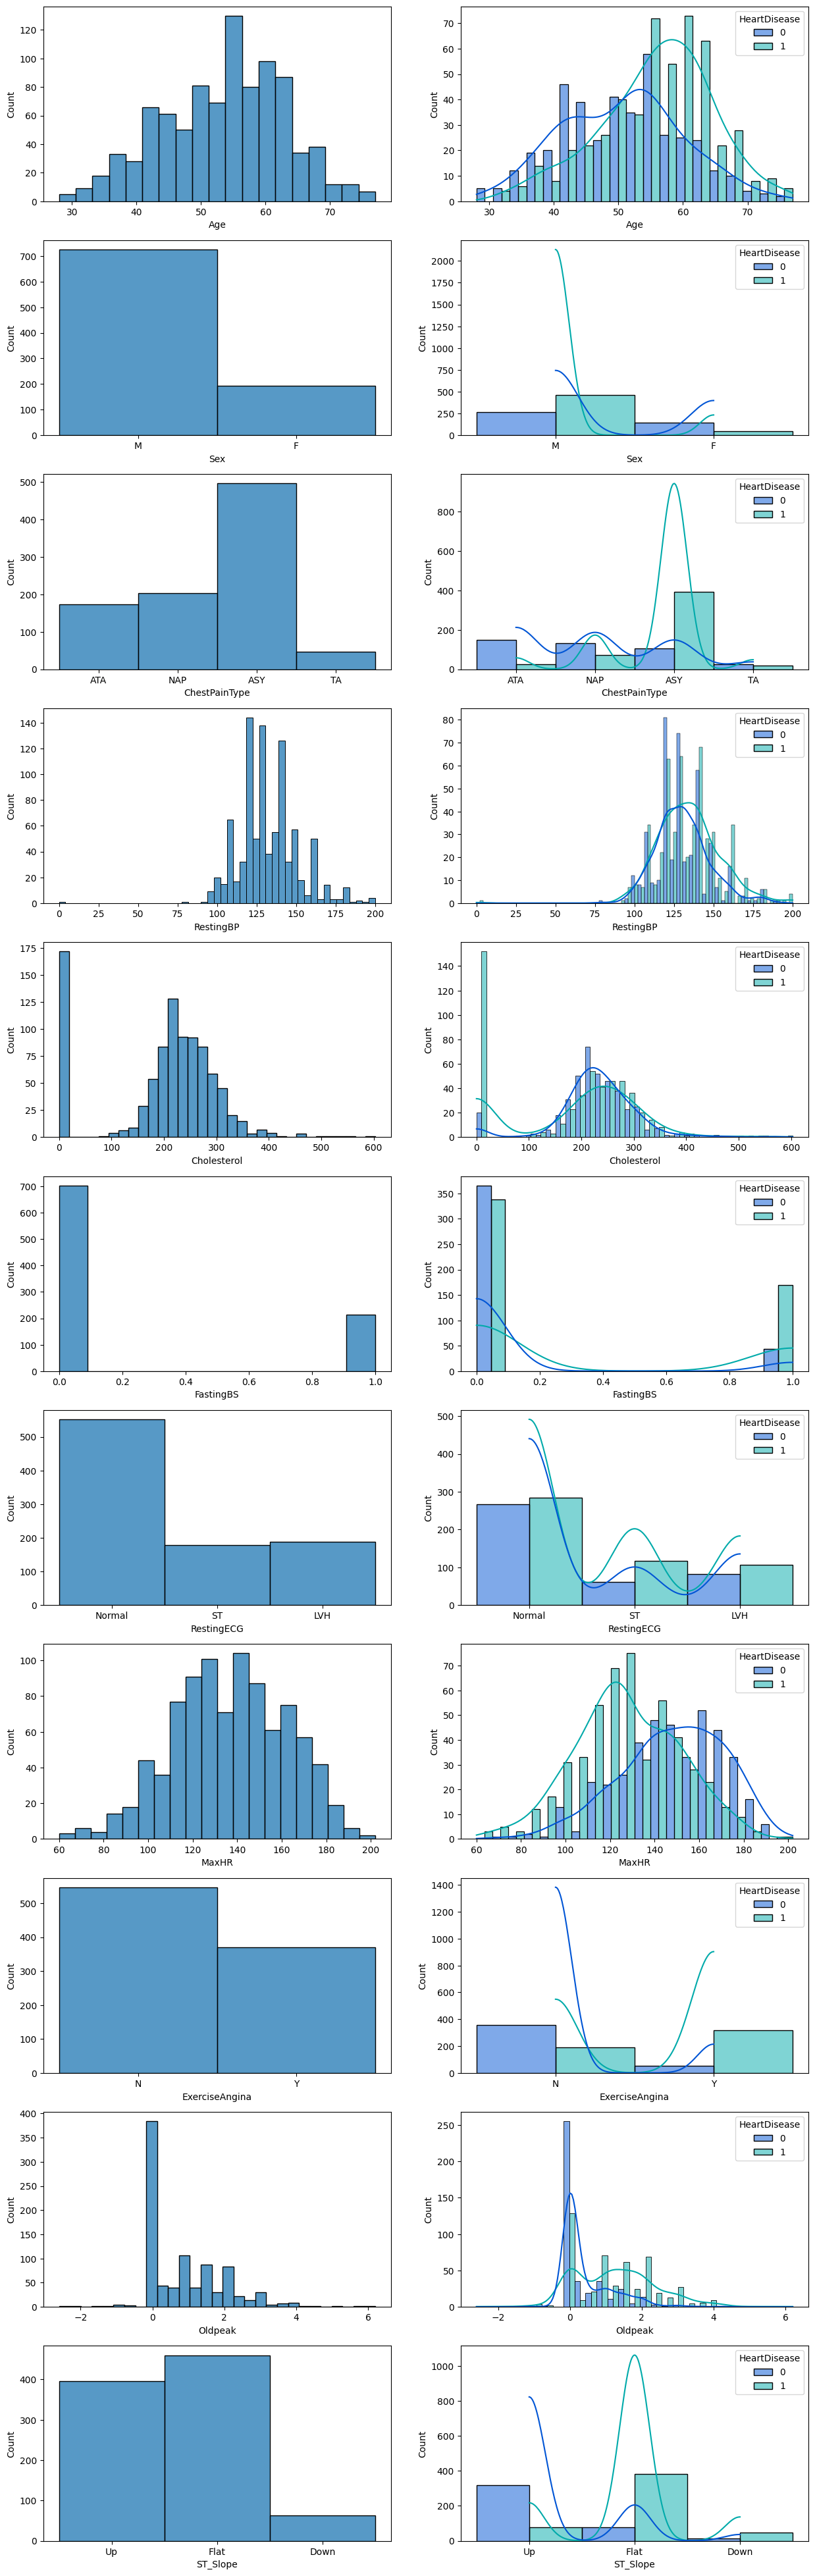

In [5]:
plt.subplots_adjust(hspace=0.4)
color = 'winter'

fig, axs = plt.subplots(11, 2, figsize=(15,50))
featureCount = 1
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and featureCount < 14:
        plt.subplot(11,2,i)
        sns.histplot(data=df, x=feature)
        i+=1
        plt.subplot(11,2,i)
        sns.histplot(data=df, x=feature, kde=True, palette=color, hue='HeartDisease', multiple = 'dodge')
        i+=1
        featureCount+=1

In [6]:
categorical_f = ["ChestPainType", "RestingECG", "ST_Slope"]

[df[i].value_counts() for i in categorical_f]

[ASY    496
 NAP    203
 ATA    173
 TA      46
 Name: ChestPainType, dtype: int64,
 Normal    552
 LVH       188
 ST        178
 Name: RestingECG, dtype: int64,
 Flat    460
 Up      395
 Down     63
 Name: ST_Slope, dtype: int64]

In [7]:
binaries_f = ["Sex", "FastingBS", "ExerciseAngina"]

[df[i].value_counts() for i in binaries_f]

[M    725
 F    193
 Name: Sex, dtype: int64,
 0    704
 1    214
 Name: FastingBS, dtype: int64,
 N    547
 Y    371
 Name: ExerciseAngina, dtype: int64]

In [8]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

## Wnioski z analizy histogramów
- Ryzyko posiadania choroby serca rośnie wraz z wiekiem.
- Męzczyźni częściej chorują.
- Największe prawdopodobieństwo choroby serca występuję przy braku bólu klatki piersiowej.
- Spoczynkowe ciśnienie krwi zawiera niewielką ilość wartości równych 0.
- Histogram cholesterolu wygląda stosunkowo ciekawie. Można zastanowić się czy wartości 0 nie są wartościami odstającymi.
- Wysoki poziom cukru we krwi na czczo sprzyja chorobą serca.
- Występowanie dławicy wysiłkowej, duże obniżenie odcinka ST po wysiłku tym samym płaskie lub wklęsłe jego nachylenie zwiększa prawdopodobieństwo posiadania choroby serca.
- Im większa wartość pulsu maksymalnego tym mniejsza szansa na chorobę serca.

## Zamiana danych kategorycznych na numeryczne

In [9]:
df['Sex'].replace(['M', 'F'], [0, 1], inplace=True)
df['ChestPainType'].replace(['TA', 'ATA', 'NAP', 'ASY'], [0, 1, 2, 3], inplace=True)
df['RestingECG'].replace(['Normal', 'ST', 'LVH'], [0, 1, 2], inplace=True)
df['ExerciseAngina'].replace(['Y', 'N'], [0, 1], inplace=True)
df['ST_Slope'].replace(['Up', 'Flat', 'Down'], [0, 1, 2], inplace=True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


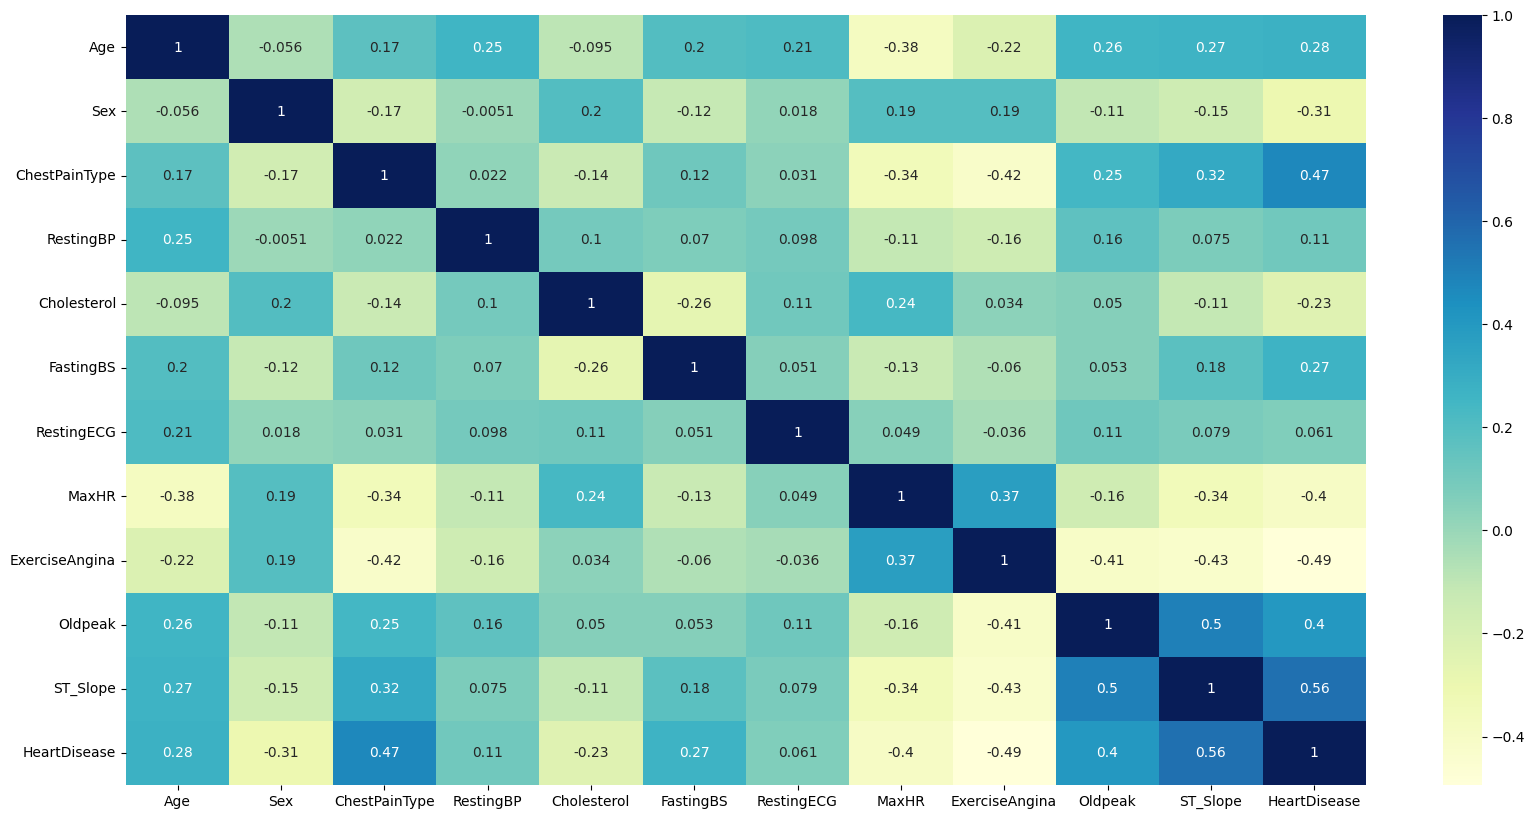

In [11]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);

# Algorytm KNN

In [12]:
# Function for measuring distance
# L=1 - manhattan distance
# L=2 - euclidean distance

def distance(x1, x2, L=2):
    return np.power(np.sum(np.power(np.abs(x1-x2), L)), 1/L)

In [13]:
class KNN:
    def __init__(self, k, L=2):
        self.k = k
        self.L = L 

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        distances = [distance(x, x_train, self.L) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_labels = [self.y_train[i] for i in k_indices]
        return Counter(k_labels).most_common()[0][0]


In [14]:
class Weighted_KNN:
    def __init__(self, k, L=2):
        self.k = k
        self.L = L 

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        distances = [distance(x, x_train, self.L) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_labels = [self.y_train[i] for i in k_indices]
        
        weightA = 0
        weightB = 0
        for i, label in zip(k_indices, k_labels):
            if label == 0:
                weightA += 1/distances[i]
            elif label == 1:
                weightB += 1/distances[i]
        
        return 0 if weightA > weightB else 1


# Przygotowanie danych

In [33]:
input = df.iloc[:, :11]
standardized = (input - input.mean()) / input.std()
normalized = (input - input.min()) / (input.max() - input.min())
X_norm = np.array(normalized)
X_std = np.array(standardized)
y = np.array(df.iloc[:, 11])

In [34]:
standardized.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,-1.432359,-0.515671,-1.344353,0.410685,0.824621,-0.551041,-0.748772,1.382175,0.823108,-0.831979,-1.051541
1,-0.478223,1.937107,-0.270275,1.490940,-0.171867,-0.551041,-0.748772,0.753746,0.823108,0.105606,0.595753
2,-1.750404,-0.515671,-1.344353,-0.129442,0.769768,-0.551041,0.491973,-1.524307,0.823108,-0.831979,-1.051541
3,-0.584238,1.937107,0.803804,0.302660,0.138964,-0.551041,-0.748772,-1.131539,-1.213585,0.574398,0.595753
4,0.051853,-0.515671,-0.270275,0.950812,-0.034736,-0.551041,-0.748772,-0.581664,0.823108,-0.831979,-1.051541


In [30]:
normalized.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.244898,0.0,0.333333,0.70,0.479270,0.0,0.0,0.788732,1.0,0.295455,0.0
1,0.428571,1.0,0.666667,0.80,0.298507,0.0,0.0,0.676056,1.0,0.409091,0.5
2,0.183673,0.0,0.333333,0.65,0.469320,0.0,0.5,0.267606,1.0,0.295455,0.0
3,0.408163,1.0,1.000000,0.69,0.354892,0.0,0.0,0.338028,0.0,0.465909,0.5
4,0.530612,0.0,0.666667,0.75,0.323383,0.0,0.0,0.436620,1.0,0.295455,0.0


# Tworzenie modelów

In [52]:
k = 9
models = {'Our KNN': KNN(k=k, L=2),
'Our WKNN': Weighted_KNN(k=k, L=2),
'SKL KNN': KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='brute'),
'SKL WKNN': KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute')}

In [51]:
for i in range(2,30):
    validation_scores = []
    test = KNeighborsClassifier(n_neighbors=i, weights='distance', algorithm='brute')
    for train_index, val_index in kfold.split(X_norm, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        test.fit(X_train, y_train)
        y_pred = test.predict(X_val)
        score = metrics.accuracy_score(y_val, y_pred)
        validation_scores.append(score)
    mean_validation_score = sum(validation_scores) / num_folds
    print(f"K = {i} Mean Validation Score: {mean_validation_score}, elapsed time: {stop-start}")

K = 2 Mean Validation Score: 0.8148351648351648, elapsed time: 0.014965599999413826
K = 3 Mean Validation Score: 0.8311872909698996, elapsed time: 0.014965599999413826
K = 4 Mean Validation Score: 0.8355470616340182, elapsed time: 0.014965599999413826
K = 5 Mean Validation Score: 0.8399068322981366, elapsed time: 0.014965599999413826
K = 6 Mean Validation Score: 0.8486144290492117, elapsed time: 0.014965599999413826
K = 7 Mean Validation Score: 0.8562470138557096, elapsed time: 0.014965599999413826
K = 8 Mean Validation Score: 0.8551600573339704, elapsed time: 0.014965599999413826
K = 9 Mean Validation Score: 0.8616937410415672, elapsed time: 0.014965599999413826
K = 10 Mean Validation Score: 0.85843287147635, elapsed time: 0.014965599999413826
K = 11 Mean Validation Score: 0.8529861442904922, elapsed time: 0.014965599999413826
K = 12 Mean Validation Score: 0.8518872431915911, elapsed time: 0.014965599999413826
K = 13 Mean Validation Score: 0.8497013855709508, elapsed time: 0.014965599

## Badanie KNN dla danych znormalizowanych (0,1)

In [53]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)

for model in models:
    validation_scores = []
    start = perf_counter()
    for train_index, val_index in kfold.split(X_norm, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_val)
        score = metrics.accuracy_score(y_val, y_pred)
        validation_scores.append(score)
    stop = perf_counter()
    mean_validation_score = sum(validation_scores) / num_folds
    print(f"{model} Mean Validation Score: {mean_validation_score}, elapsed time: {stop-start}")

Our KNN Mean Validation Score: 0.8529861442904922, elapsed time: 4.935871800000314
Our WKNN Mean Validation Score: 0.8616937410415672, elapsed time: 4.933668200003012
SKL KNN Mean Validation Score: 0.8529861442904922, elapsed time: 0.02655109999977867
SKL WKNN Mean Validation Score: 0.8616937410415672, elapsed time: 0.014511100001982413


## Badanie KNN dla danych ustandaryzowanych

In [54]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)

for model in models:
    validation_scores = []
    start = perf_counter()
    for train_index, val_index in kfold.split(X_std, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_val)
        score = metrics.accuracy_score(y_val, y_pred)
        validation_scores.append(score)
    stop = perf_counter()
    mean_validation_score = sum(validation_scores) / num_folds
    print(f"{model} Mean Validation Score: {mean_validation_score}, elapsed time: {stop-start}")

Our KNN Mean Validation Score: 0.8529861442904922, elapsed time: 4.979519900000014
Our WKNN Mean Validation Score: 0.8616937410415672, elapsed time: 4.973559699999896
SKL KNN Mean Validation Score: 0.8529861442904922, elapsed time: 0.027217399998335168
SKL WKNN Mean Validation Score: 0.8616937410415672, elapsed time: 0.014668200001324294


In [ ]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix())